# Data Modelling

Since as of now I only know KNN, Logistic Regression and Decision Tree Classifiers, I wil stick to those for time being. Also I will employ GridSearchCV to figure out the best parameters for each algorithm

In [59]:
import pandas as pd
import numpy as np

# get the data from the file
file_path = './data/preprocessed_all_tweets.csv'  # Update path as needed
embedded_data = pd.read_csv(file_path)
X = embedded_data['processed_text']
y = embedded_data['hashtag']

# split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((372,), (93,), (372,), (93,))

In [60]:
# create a custom vectorizer class
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

class CustomVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, method='count', **kwargs):
        """
        Custom vectorizer that can switch between CountVectorizer and TfidfVectorizer.
        
        Parameters:
        - method: 'count' for CountVectorizer or 'tfidf' for TfidfVectorizer
        - kwargs: Additional parameters to be passed to the vectorizer
        """
        self.method = method
        self.kwargs = kwargs
        self.vectorizer = None

    def get_params(self, deep=True):
        """Return parameters for this estimator."""
        params = {"method": self.method}
        params.update(self.kwargs)
        return params

    def set_params(self, **params):
        """Set parameters for this estimator."""
        if "method" in params:
            self.method = params.pop("method")
        self.kwargs.update(params)
        return self

    def fit(self, X, y=None):
        # Initialize the vectorizer based on the selected method
        if self.method == 'count':
            self.vectorizer = CountVectorizer(**self.kwargs)
        elif self.method == 'tfidf':
            self.vectorizer = TfidfVectorizer(**self.kwargs)
        else:
            raise ValueError("Invalid method. Choose 'count' or 'tfidf'.")

        # Fit the vectorizer
        self.vectorizer.fit(X)
        return self

    def transform(self, X):
        # Transform the data using the chosen vectorizer
        if not self.vectorizer:
            raise ValueError("Vectorizer not initialized. Call fit() first.")
        return self.vectorizer.transform(X)

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X)


# Various models with Grid Search CV to figure out the best parameters


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import time

# suppress warnings
import warnings
from sklearn.exceptions import ConvergenceWarning
# Ignore ConvergenceWarning
warnings.filterwarnings("ignore", category = ConvergenceWarning)
# Suppress FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)

params = {
    'vectorizer__method': ['tfidf', 'count'],
    'vectorizer__stop_words': ['english', None],
    'vectorizer__max_features': [100, 500, None]
}

pipelines = {
    'Logistic Regression': Pipeline([
        ('vectorizer', CustomVectorizer()),
        ('classifier', OneVsRestClassifier(LogisticRegression(max_iter=1000)))
    ]),
    'Decision Tree': Pipeline([
        ('vectorizer', CustomVectorizer()),
        ('classifier', DecisionTreeClassifier())
    ]),
    'KNN': Pipeline([
        ('vectorizer', CustomVectorizer()),
        ('classifier', KNeighborsClassifier())
    ]),
    'Naive Bayes': Pipeline([
        ('vectorizer', CustomVectorizer()),
        ('classifier', MultinomialNB())
    ])
}

def copy_and_update(d, new_values):
    new_dict = d.copy()
    new_dict.update(new_values)
    return new_dict

# Logistic Regression
param_grid_lr = {
    'classifier__estimator__C': [0.1, 1, 10],
    'classifier__estimator__solver': ['lbfgs', 'saga']
}
param_grid_dt = {
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10]
}
param_grid_knn = {
    'classifier__n_neighbors': [3, 5, 7],
    'classifier__weights': ['uniform', 'distance']
}
param_grid_nb = {
    'alpha': [0.1, 0.5, 1.0]  # Smoothing parameter
}

param_grids = {
    'Logistic Regression': copy_and_update(params, param_grid_lr),
    'Decision Tree': copy_and_update(params, param_grid_dt),
    'KNN': copy_and_update(params, param_grid_knn),
    'Naive Bayes': copy_and_update(params, {'classifier__alpha': [0.1, 1.0, 10.0]})
}

# Running GridSearchCV for each pipeline
grid_search_results = {}
for name, pipeline in pipelines.items():
    print(f'Running GridSearchCV for {name}')
    # note the time taken to run the grid search
    start_time = time.time()
    grid_search = GridSearchCV(pipeline, param_grids[name], cv=3, scoring='f1_micro', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    end_time = time.time()
    print(f'... completed in {end_time - start_time:.2f} seconds')
    grid_search_results[name] = grid_search

hashtags = embedded_data['hashtag'].unique()

# Collecting results for comparison
results_summary = []
cms = {}
for name, grid_search in grid_search_results.items():
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    test_score = grid_search.score(X_test, y_test)
    y_pred = grid_search.predict(X_test)
    print(classification_report(y_test, y_pred, output_dict=True))
    mean_fit_time = grid_search.cv_results_['mean_fit_time'].mean()
    mean_score_time = grid_search.cv_results_['mean_score_time'].mean()
    results_summary.append((name, best_params, best_score, test_score, mean_fit_time, mean_score_time))
    cms[name] = confusion_matrix(y_test, y_pred, labels=hashtags)
    
# Converting the results to a DataFrame for better presentation
results_df = pd.DataFrame(results_summary, columns=['Model', 'Best Parameters', 'Training Score', 'Test Score', 'Mean Fit Time', 'Mean Test Time'])

results_df.set_index('Model', inplace=True)

In [62]:
# Convert results to a DataFrame and display
results_df

,Best Parameters,Training Score,Test Score,Mean Fit Time,Mean Test Time
Model,,,,,
Logistic Regression,"{'classifier__estimator__C': 1, 'classifier__e...",0.607527,0.666667,0.098620,0.003018
Decision Tree,"{'classifier__max_depth': None, 'classifier__m...",0.481183,0.505376,0.006460,0.002184
KNN,"{'classifier__n_neighbors': 7, 'classifier__we...",0.564516,0.612903,0.004371,0.003386
Naive Bayes,"{'classifier__alpha': 0.1, 'vectorizer__max_fe...",0.594086,0.677419,0.006892,0.002659


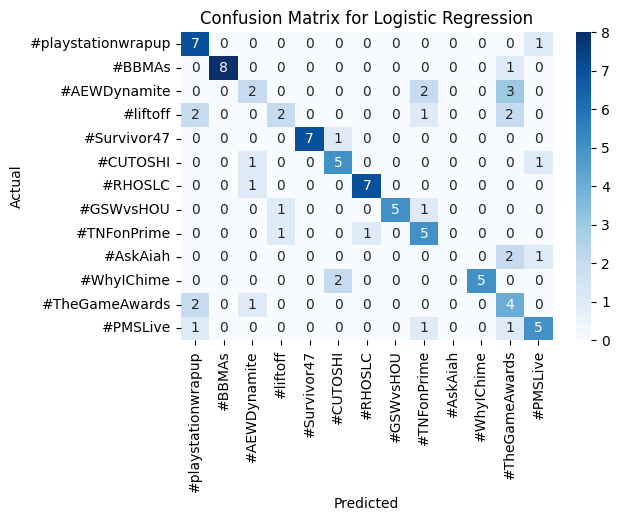

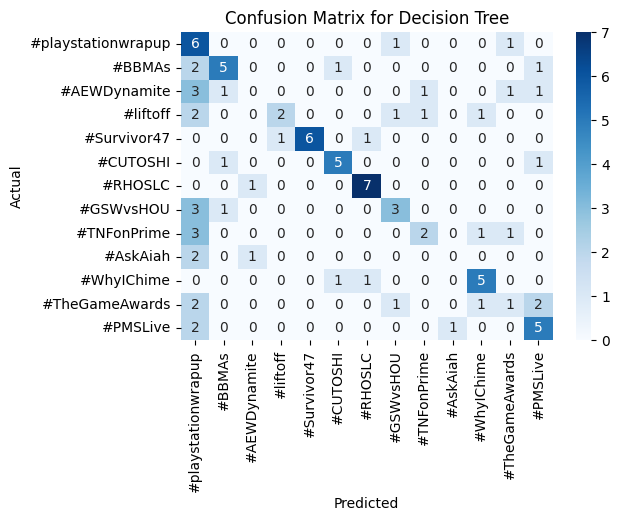

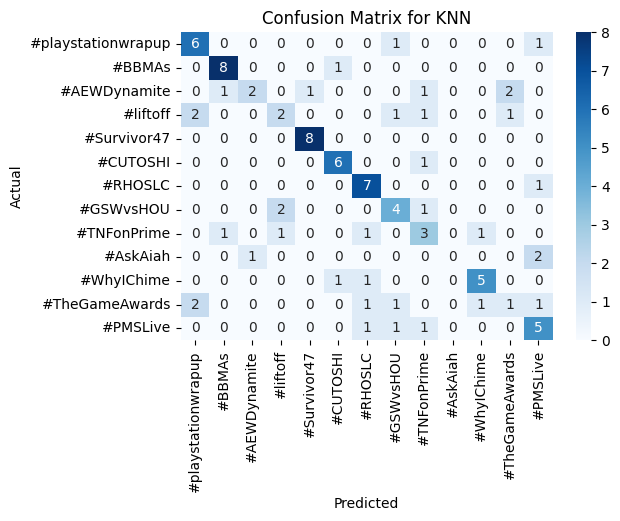

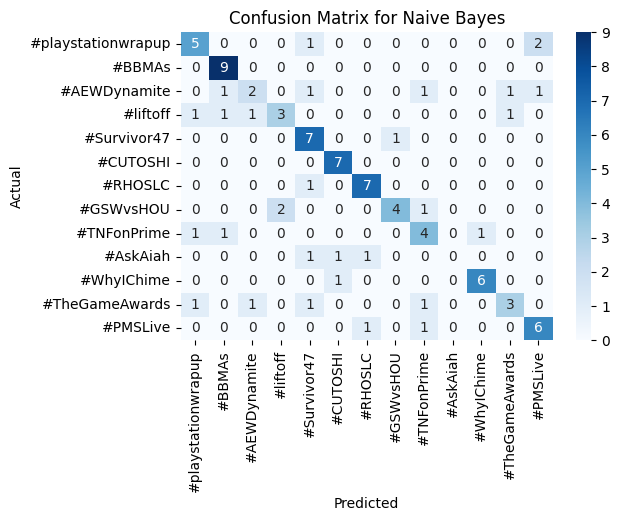

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

# show the confusion matrix for each model
for name, cm in cms.items():
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=hashtags, yticklabels=hashtags)
    plt.title(f"Confusion Matrix for {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report


# Using BERT embeddings
file_path = './data/embedded_all_tweets.csv'  # Update path as needed
embedded_data = pd.read_csv(file_path)

# Convert BERT embeddings from string to numerical arrays
embedded_data['bert_embedding'] = embedded_data['bert_embedding'].apply(
    lambda x: np.array([float(i) for i in x.strip('[]').split()])
)
# Prepare features (BERT embeddings)
X = np.vstack(embedded_data['bert_embedding'])

# Prepare targets (multi-label binary format for hashtags)
unique_hashtags = embedded_data['hashtag'].unique()
mlb = MultiLabelBinarizer(classes=unique_hashtags)
y = embedded_data['hashtag'] # mlb.fit_transform(embedded_data['hashtag'].apply(lambda x: [x] if isinstance(x, str) else []))

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Initialize a results list
results = []

# Logistic Regression
param_grid_lr = {
    'C': [0.1, 1, 10],
    'solver': ['lbfgs', 'saga']
}
logistic_model = LogisticRegression(max_iter=1000, multi_class='ovr')
grid_search_lr = GridSearchCV(logistic_model, param_grid_lr, cv=3, scoring='f1_micro', n_jobs=-1, return_train_score=True)
grid_search_lr.fit(X_train, y_train)
best_lr_model = grid_search_lr.best_estimator_
y_pred_lr = best_lr_model.predict(X_test)
results.append({
    'Model': 'Logistic Regression (BERT)',
    'Best Parameters': grid_search_lr.best_params_,
    'Training Score': grid_search_lr.best_score_,
    'Test Score': classification_report(y_test, y_pred_lr, output_dict=True)['accuracy'],
    'Mean Fit Time': grid_search_lr.cv_results_['mean_fit_time'].mean(),
    'Mean Test Time': grid_search_lr.cv_results_['mean_score_time'].mean()
})

# Decision Tree
param_grid_dt = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
decision_tree = DecisionTreeClassifier()
grid_search_dt = GridSearchCV(decision_tree, param_grid_dt, cv=3, scoring='f1_micro', n_jobs=-1, return_train_score=True)
grid_search_dt.fit(X_train, y_train)
best_dt_model = grid_search_dt.best_estimator_
y_pred_dt = best_dt_model.predict(X_test)
results.append({
    'Model': 'Decision Tree (BERT)',
    'Best Parameters': grid_search_dt.best_params_,
    'Training Score': grid_search_dt.best_score_,
    'Test Score': classification_report(y_test, y_pred_dt, output_dict=True)['accuracy'],
    'Mean Fit Time': grid_search_dt.cv_results_['mean_fit_time'].mean(),
    'Mean Test Time': grid_search_dt.cv_results_['mean_score_time'].mean()
})

# K-Nearest Neighbors
param_grid_knn = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance']
}
knn_model = KNeighborsClassifier()
grid_search_knn = GridSearchCV(knn_model, param_grid_knn, cv=3, scoring='f1_micro', n_jobs=-1, return_train_score=True)
grid_search_knn.fit(X_train, y_train)
best_knn_model = grid_search_knn.best_estimator_
y_pred_knn = best_knn_model.predict(X_test)
results.append({
    'Model': 'KNN (BERT)',
    'Best Parameters': grid_search_knn.best_params_,
    'Training Score': grid_search_knn.best_score_,
    'Test Score': classification_report(y_test, y_pred_knn, output_dict=True)['accuracy'],
    'Mean Fit Time': grid_search_knn.cv_results_['mean_fit_time'].mean(),
    'Mean Test Time': grid_search_knn.cv_results_['mean_score_time'].mean()
})

# Convert results to a DataFrame and display
results_bert_df = pd.DataFrame(results)

In [65]:
results_bert_df.set_index('Model', inplace=True)
results_bert_df

,Best Parameters,Training Score,Test Score,Mean Fit Time,Mean Test Time
Model,,,,,
Logistic Regression (BERT),"{'C': 1, 'solver': 'lbfgs'}",0.413978,0.494624,2.951136,0.001399
Decision Tree (BERT),"{'max_depth': 30, 'min_samples_split': 2}",0.172043,0.182796,0.152462,0.001437
KNN (BERT),"{'n_neighbors': 3, 'weights': 'distance'}",0.303763,0.301075,0.000918,0.004298


In [69]:
merged_results = pd.concat([results_df, results_bert_df])
merged_results
merged_results.to_csv('./data/final_results.csv')
merged_results

,Best Parameters,Training Score,Test Score,Mean Fit Time,Mean Test Time
Model,,,,,
Logistic Regression,"{'classifier__estimator__C': 1, 'classifier__e...",0.607527,0.666667,0.098620,0.003018
Decision Tree,"{'classifier__max_depth': None, 'classifier__m...",0.481183,0.505376,0.006460,0.002184
KNN,"{'classifier__n_neighbors': 7, 'classifier__we...",0.564516,0.612903,0.004371,0.003386
Naive Bayes,"{'classifier__alpha': 0.1, 'vectorizer__max_fe...",0.594086,0.677419,0.006892,0.002659
Logistic Regression (BERT),"{'C': 1, 'solver': 'lbfgs'}",0.413978,0.494624,2.951136,0.001399
Decision Tree (BERT),"{'max_depth': 30, 'min_samples_split': 2}",0.172043,0.182796,0.152462,0.001437
KNN (BERT),"{'n_neighbors': 3, 'weights': 'distance'}",0.303763,0.301075,0.000918,0.004298


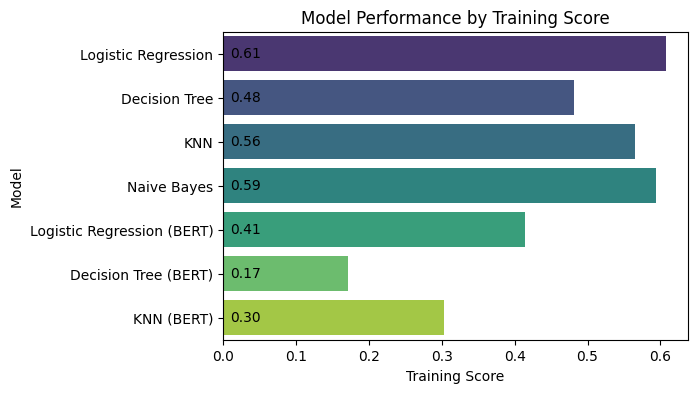

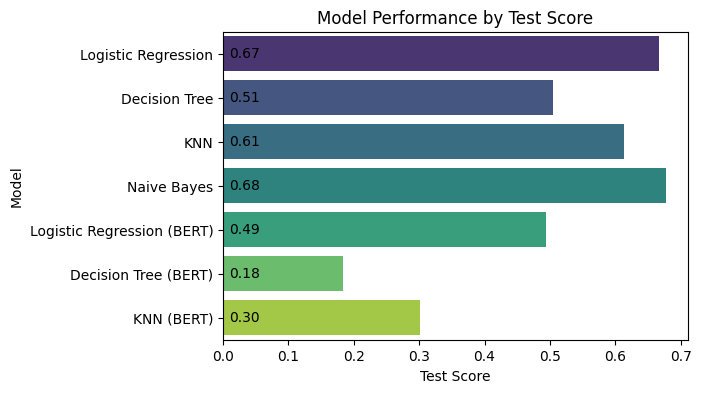

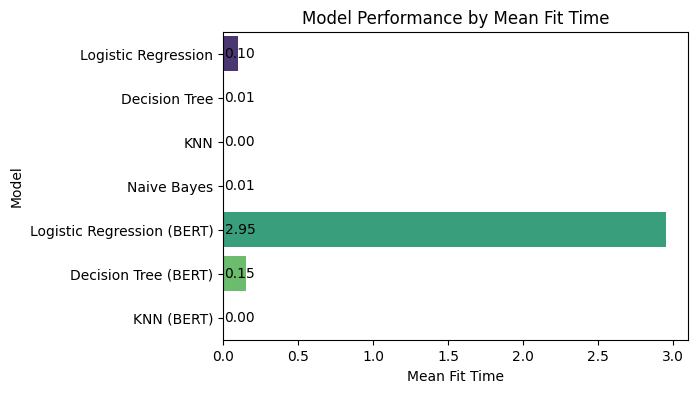

In [67]:
# Plotting the results
import matplotlib.pyplot as plt
import seaborn as sns

for parameter in ['Training Score', 'Test Score', 'Mean Fit Time']:

    # Set the figure size
    plt.figure(figsize=(6, 4))

    # Create a barplot of the test scores
    sns.barplot(data=merged_results, x=parameter, y=merged_results.index, palette='viridis')

    # Add the score values on the bars
    for i in range(merged_results.shape[0]):
        plt.text(0.01, i, f"{merged_results[parameter].iloc[i]:.2f}", va='center')

    # Add labels and title
    plt.xlabel(parameter)
    plt.ylabel('Model')
    #plt.xticks(rotation=75)
    plt.title(f'Model Performance by {parameter}')
    plt.show()
